In [2]:
import nibabel as nib
import os
import torch
from utils import viewer_3d,show_mv,plt_images,complex_pyramid,complex_NLL,complex_total_variation
import torchvision.transforms.functional as F1
from torchvision.transforms import v2
import torch.nn.functional as F
import torchfields
from complexPyTorch.complexFunctions import complex_upsample, complex_upsample2
import kornia as K
from tqdm import tqdm

In [3]:
from matplotlib import pyplot as plt
def plt_images(slices_list, z,title):
  """

  :param slices_list: Ex : [10,11,12,13,14,15]
  :param z: The list that contains all tensors. Ex : To plot (img+,img-) -> z = [img_pos,img_inv]
  :return:
  """

  # minmin = torch.min(torch.min(z[0]), torch.min(z[-1]))
  # maxmax = torch.max(torch.max(z[0]), torch.max(z[-1]))
  slices = slices_list
  i = 0
  rows = len(z)
  cols = len(slices)
  f, ax = plt.subplots(rows, cols)
  f.set_figheight(8)
  f.set_figwidth(16)
  f.suptitle(title,fontsize=18)


  for r in range(rows):
    for c in range(cols):
      temp = z[r]
      slice_num = slices[i]
      temp = ax[r, c].imshow(temp[slice_num,], cmap='gray')
      ax[r, c].set_title("Slice = " + str(slice_num))
      ax[r, c].axis('off')

      cbar = f.colorbar(temp,ticklocation="bottom")
      cbar.ax.tick_params(labelsize=7)
      # cbar.set_ticks(ticks=[minmin,maxmax], labels = [float("{:.f}".format(minmin)),float("{:.4f}".format(maxmax))])

      i += 1
    i = 0
  plt.show()

In [4]:
file1 = '/Users/pi58/Library/CloudStorage/Box-Box/PhD/Datasets/ExBox20/nodif.nii.gz'
file2 = '/Users/pi58/Library/CloudStorage/Box-Box/PhD/Datasets/ExBox20/nodif_PA.nii.gz'
img1 = nib.load(file1)
img2 = nib.load(file2)
print(img1.shape,img2.shape)

(116, 116, 76) (116, 116, 76)


In [5]:
img1  = torch.from_numpy(img1.get_fdata())
img2  = torch.from_numpy(img2.get_fdata())
img1 = torch.permute(img1,(2,0,1))
img2 = torch.permute(img2,(2,0,1))
print(img1.shape,img2.shape)

torch.Size([76, 116, 116]) torch.Size([76, 116, 116])


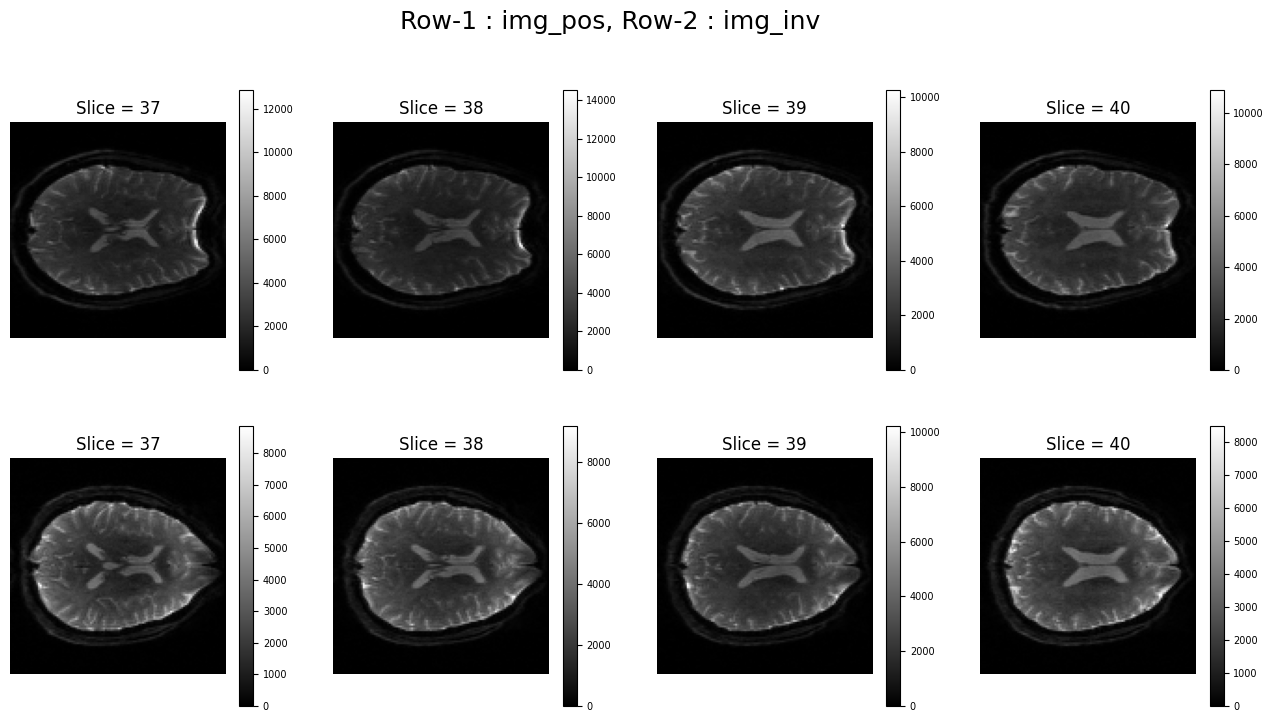

In [6]:
slices = [37,38,39,40]
z = [img1,img2]
plt_images(slices,z,"Row-1 : img_pos, Row-2 : img_inv")

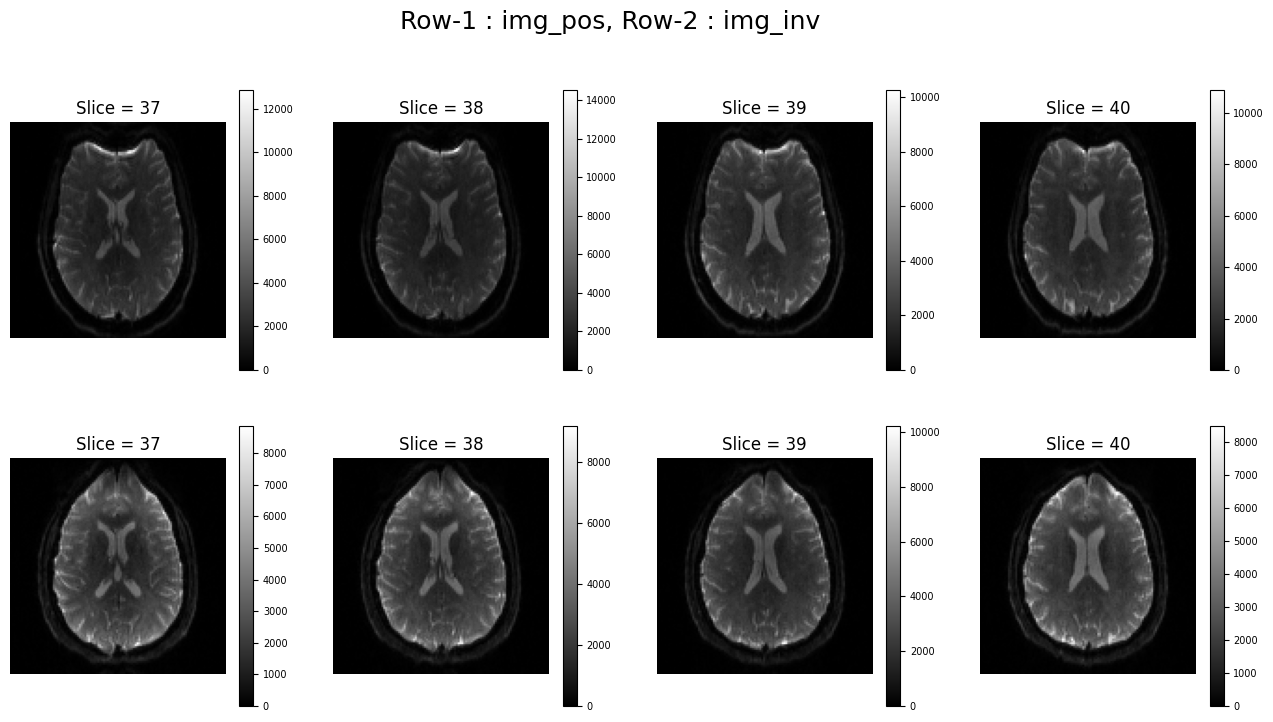

In [7]:
rotated1 = torch.rot90(img1, 1,[1,2])
rotated2 = torch.rot90(img2, 1,[1,2])
z = [rotated1,rotated2]
plt_images(slices,z,"Row-1 : img_pos, Row-2 : img_inv")

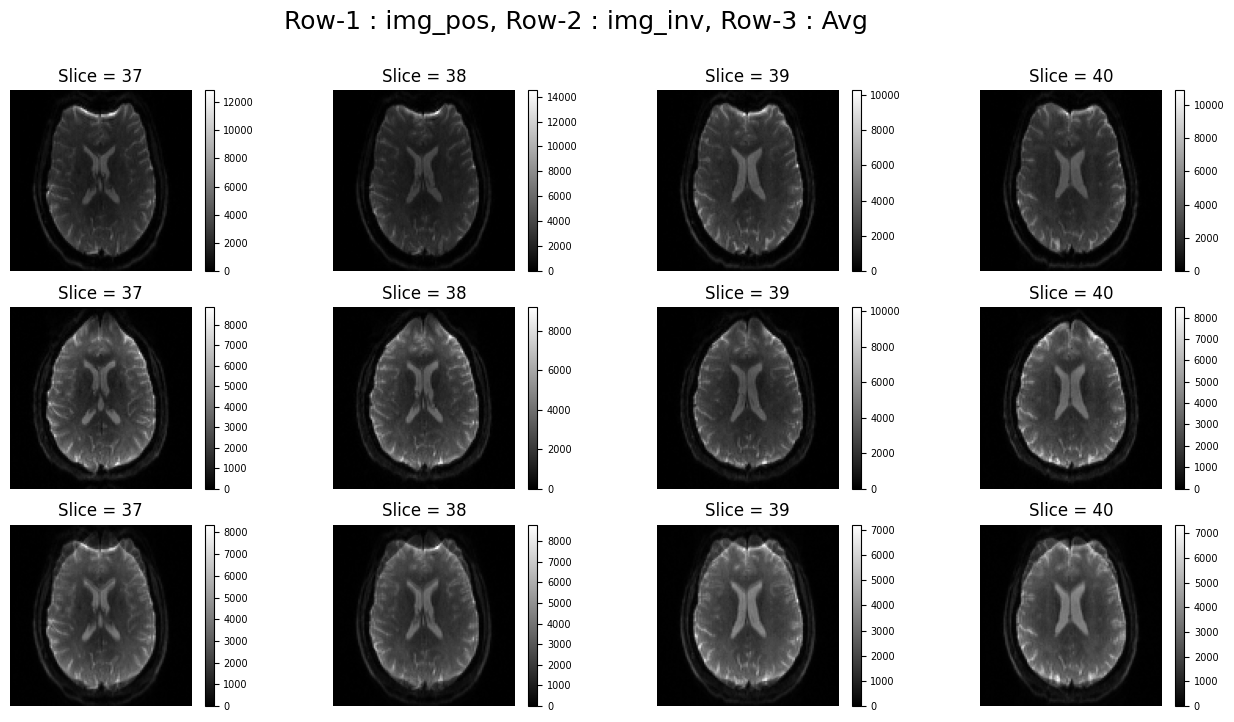

In [8]:
avg = (rotated1+rotated2)/2
z = [rotated1,rotated2,avg]
plt_images(slices,z,"Row-1 : img_pos, Row-2 : img_inv, Row-3 : Avg")

In [9]:
img_pos = rotated1
img_inv = rotated2

img_pos_pyramid = K.geometry.transform.build_pyramid(img_pos.reshape(1,img_pos.shape[-3],img_pos.shape[-1],img_pos.shape[-1]),3)
img_inv_pyramid = K.geometry.transform.build_pyramid(img_inv.reshape(1,img_pos.shape[-3],img_pos.shape[-1],img_pos.shape[-1]),3)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


/var/folders/jn/htj79lg12cg80r08kmc0y55h00z9nl/T/ipykernel_77201/679360502.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  template_img = torch.tensor((img_pos_pyramid[-1]+img_inv_pyramid[-1])/2,requires_grad=True)


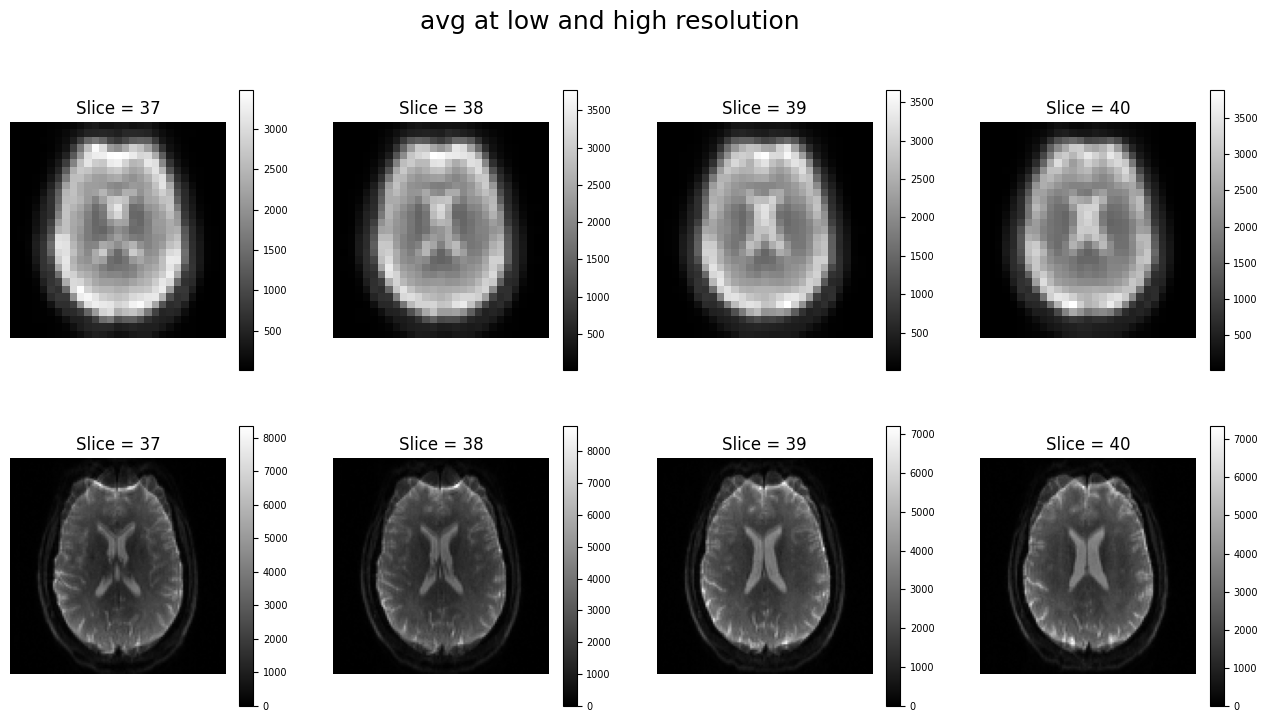

In [10]:
template_img = torch.tensor((img_pos_pyramid[-1]+img_inv_pyramid[-1])/2,requires_grad=True)
# template_img = blurrer(template_img)
w = torch.Field.identity(1,2,29,29,requires_grad=True)
avg = template_img.clone().detach()
avg = avg.reshape(avg.shape[-3],avg.shape[-1],avg.shape[-1])
avg2 = ((img_pos_pyramid[0]+img_inv_pyramid[0])/2)
avg2 = avg2.reshape(avg2.shape[-3],avg2.shape[-1],avg2.shape[-1])
z = [avg,avg2]
plt_images(slices,z,"avg at low and high resolution")

In [11]:
def forward_model(w,template_img,brightness_factor):
    #W = Transformation matrix (Deformation matrix) (Warping matrix) (theta)
    ratio = brightness_factor
    img = template_img.reshape(1,template_img.shape[-3],template_img.shape[-1],template_img.shape[-1]).float()
    #Warping
    img1 = w(img)
    # img2 = torch.zeros_like(img1)
    # img = F1.adjust_brightness(img.reshape(-1,1,template_img.shape[-1],template_img.shape[-1]),brightness_factor).reshape(1,35,template_img.shape[-1],template_img.shape[-1])
    # img = (ratio * img1 + (1.0 - ratio) * img2).clamp(0, 1).to(img1.dtype)  #Adjusting Brightness Factor
    #ift = torch.matmul(K,img())
    # img = torch.fft.fftn(img)
    return img1

In [12]:
def optimize_template(epochs, learning_rate, w, template_img, img_pos, img_inv, brightness_factor):
    template_image_list = []
    w_list = []
    losses = []
    # losses_list_1, losses_list_2, losses_list_3, losses_list_4 = [],[],[],[]
    # losses_list = [losses_list_1,losses_list_2,losses_list_3,losses_list_4]
    
    loss = torch.nn.GaussianNLLLoss()
    total_variation = K.losses.TotalVariation()
    # print(template_img.shape,template_img.is_leaf)
    
  
    optimizer = torch.optim.LBFGS([w, template_img, brightness_factor], lr=learning_rate, max_iter=20)
    for t in tqdm(range(epochs)):
        # w = f1(g)
        def closure():
            optimizer.zero_grad()
            # model_variable_1 = forward_model_multi_resolution(w, template_img,brightness_factor)  # 1
            # model_variable_2 = forward_model_multi_resolution(-w, template_img,brightness_factor)  # 1
            pred1 = forward_model(w,template_img,brightness_factor)
            pred2 = forward_model(-w,template_img,brightness_factor)
            # print(pred1.shape)

            # z1 = template_img.reshape(35,template_img.shape[-1],template_img.shape[-1]).detach()
            # z = [z1,avg2,img_pos.reshape(35,img_pos.shape[-1],img_pos.shape[-1]),img_inv.reshape(35,img_pos.shape[-1],img_pos.shape[-1])]
            # plt.clf()
            # plt_images(slices,z,"Row - 1 : Optimized template, Row-2 : Initial template, Row-3 : img_pos, Row-4 : img_inv ")
            
      
            # l1 = complex_NLL(f_pos_pyramid[i], model_variable_1)  # 2.1
            # l2 = complex_NLL(f_inv_pyramid[i], model_variable_2)  # 2.2
            l1 = loss(img_pos,pred1,torch.ones_like(img_pos)*0.1)
            l2 = loss(img_inv,pred2,torch.ones_like(img_inv)*0.1)        
            l3 = total_variation(pred1) + total_variation(pred2)
            l3 = l3.mean()
            
    
            NLL = l1 + l2 + (9e-8 * l3)
            
            
            # losses.append(NLL.item())  # To plot the loss graph
            # list_dict[i].append(NLL.item())
            # print(NLL.shape)
            NLL.backward()
            
            return NLL

        optimizer.step(closure)

        template_image_list.append(template_img)
        w_list.append(w)
        # print(brightness_factor.grad)
        # loss_list.append(losses)
        # template_img.retain_grad()
        # w.retain_grad()
        # brightness_factor.retain_grad()
        # f1.retain_grad()
        # g.retain_grad()
    return template_image_list, w_list, brightness_factor,losses

In [15]:
w = torch.Field.identity(1,2,116,116,requires_grad=True)
# template_img = torch.tensor((img_pos_pyramid[-1]+img_inv_pyramid[-1])/2,requires_grad=True)
template_img = torch.tensor(((img_pos+img_inv)/2),requires_grad=True)
brightness_factor = torch.ones(1, 1,requires_grad=True) 
list_dict = {}
list_dict[0] = []
list_dict[1] = []
list_dict[2] = []
list_dict[3] = []

template_image_list, w_list, brightness_factor,losses = optimize_template(35,0.09,w,template_img,img_pos,img_inv, brightness_factor)

/var/folders/jn/htj79lg12cg80r08kmc0y55h00z9nl/T/ipykernel_77201/4198077775.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  template_img = torch.tensor(((img_pos+img_inv)/2),requires_grad=True)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [01:32<00:00,  2.64s/it]


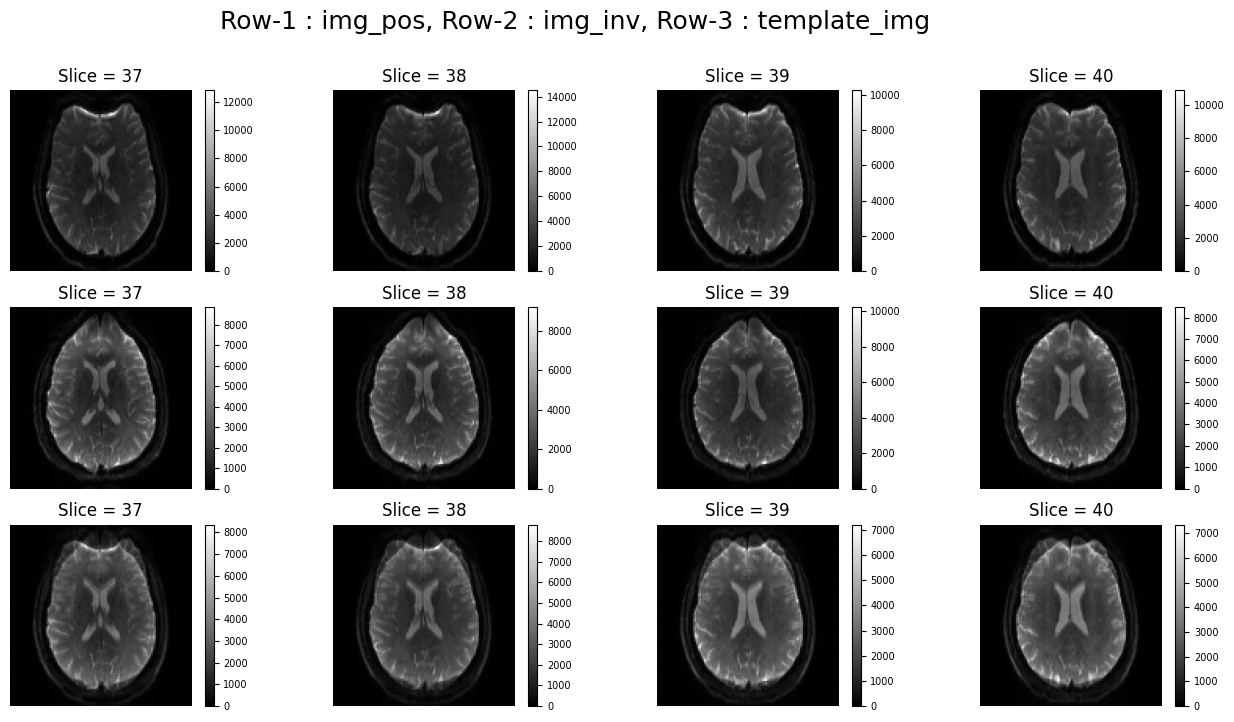

In [16]:
z = [img_pos,img_inv,template_img.detach()]
plt_images(slices,z,"Row-1 : img_pos, Row-2 : img_inv, Row-3 : template_img")

In [ ]:
from matplotlib import pyplot as plt
def plt_images_2(slices_list, z,title_list,row_list,vmax_list):
    
    
    """
    
    :param slices_list: Ex : [10,11,12,13,14,15]
    :param z: The list that contains all tensors. Ex : To plot (img+,img-) -> z = [img_pos,img_inv]
    :return:
    """
    
    # minmin = torch.min(torch.min(z[0]), torch.min(z[-1]))
    # maxmax = torch.max(torch.max(z[0]), torch.max(z[-1]))
    slices = slices_list
    i = 0
    rows = len(z)
    cols = len(slices)
    f, ax = plt.subplots(rows, cols)
    f.set_figheight(16)
    f.set_figwidth(20)
    # f.suptitle(title,fontsize=18)
    # f.supylabel("fsdfsd")
    # f.set_ylabel("fdsfsd")
      
    for r in range(rows):
        for c in range(cols):
          temp = z[r]
          slice_num = slices[i]
          temp = ax[r, c].imshow(temp[slice_num,], cmap='gray',vmin=0,vmax =vmax_list[r])
          ax[r, c].set_title("Slice = " + str(slice_num),fontsize=7,loc='center')
          ax[r, c].tick_params(labelsize=5)
          # ax[r,:].set_ylabel("fsfdfsdfs")
            
          # ax[r, c].axis('off')
        
          cbar = f.colorbar(temp,ticklocation="bottom",shrink=0.5)
          cbar.ax.tick_params(labelsize=6)
          # cbar.set_ticks(ticks=[minmin,maxmax], labels = [float("{:.f}".format(minmin)),float("{:.4f}".format(maxmax))])
        
          i += 1
        i = 0

    # Label rows and columns
    # for ax, ve in zip(axs[0], [0.1, 1, 10]):
    #     ax.set_title(f'{ve}', size=18)
    for ax, v_title,h_title  in zip(ax[:, 0], title_list,row_list):
        ax.set_ylabel(v_title, size=9)
        ax.text(-25,-5,h_title, size=7,verticalalignment='center',horizontalalignment='center',rotation=0)
    
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()

In [ ]:
vmax_list = [12000,8000,7000]
v_list = ["phase-encode","phase-reverse","optimised template"]
h_list = ["mag","mag","mag"]
z = [img_pos,img_inv,template_ig]

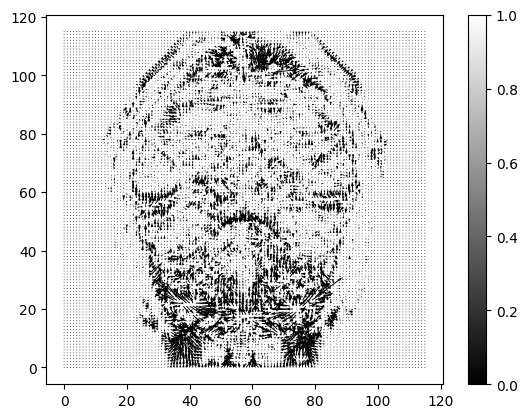

In [19]:
import utils
utils.plot_distortion_field(w_list[-1])